# Опциональные подгрузки библиотек(если версия старая)

In [1]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install accelerate -U

In [6]:
!pip install nltk

# Загрузка данных и первичный анализ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re


from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import gdown

In [2]:
from nltk.corpus import stopwords
import nltk

In [3]:
url = "https://drive.google.com/drive/folders/1Df8XPJNz2k2O8K_7NJ9hPBceRB6oa8gB"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/spam_dataset/test_spam.csv', '/content/spam_dataset/train_spam.csv']

In [4]:
df_train = pd.read_csv("spam_dataset/train_spam.csv")
df_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


`Проверяем данные на пропуски`

In [5]:
df_train.shape

(16278, 2)

In [6]:
df_train.isna().sum().sum()

0

`Данные не имеют пропусков`

In [7]:
duplicateRows = df_train[df_train.duplicated()]
duplicateRows

,text_type,text
4145,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4463,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
5640,ham,/ban
6933,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7663,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7918,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
9790,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
10290,ham,SPAM DETECTION User: Username: @DillyBubb...
10811,ham,SPAM DETECTION User: Username: @DillyBubb...
13210,ham,SPAM DETECTION User: Username: @DillyBubb...


In [ ]:
duplicateRows["text"].values

`В данных есть странные дупликаты логов какой-то модели, которая скорит  сообщения на почте по вероятности спам или не спам`

In [9]:
# удаляем дупликаты
df_train = df_train.drop_duplicates()

In [10]:
df_train[df_train.text_type == "ham"].head(5)["text"].values

array(['make sure alex knows his birthday is over in fifteen minutes as far as youre concerned',
       'a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks',
       'overview of hr associates analyst project per david s request attached is an overview of the hr associates analysts project creating a human resource value index this document will provide a brief top line overview of the following description of the challenges people involved positive outcomes high level description of the process we suggest if you have any que

In [11]:
df_train[df_train.text_type == "spam"].head(5)["text"].values

array(['plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads😊😊😊😊😁',
       'urgent your mobile number has been awarded with a £2000 prize guaranteed call 09061790121 from land line claim 3030 valid 12hrs only 150ppm',
       'i am so greatful to mrs valerie dodson for helping change my life she gives free bitcoins to newly subscribed members and her trading signals are accurate just click on the link below',
       'welcome to jefferson pilot s gateway to wealth as one of the industry s premier producers you must continually seek qualified cutting edge services financial profiles concept profiles professional is a personal and business analysis tool that analyzes a client s insurance investment and financial planning goals to help them see their situation today compared to their objectives market profiles professional is an ideal tool for true financial planning it not only provides a thorough analysis including asset

`Посмотрим на распределение данных`

<Axes: xlabel='count', ylabel='text_type'>

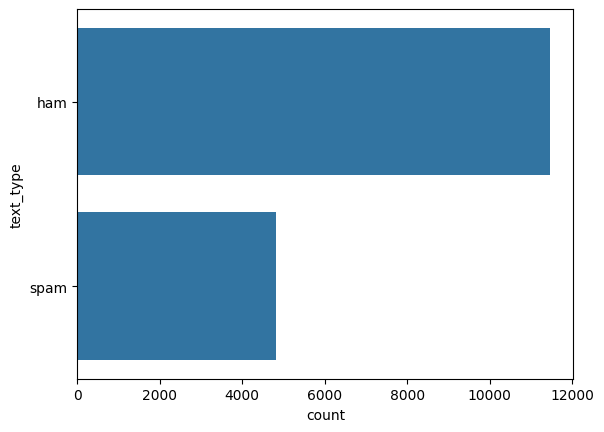

In [12]:
sns.countplot(df_train["text_type"])

In [13]:
df_train.text_type.value_counts()

text_type
ham     11458
spam     4809
Name: count, dtype: int64

In [14]:
num_ham = df_train.text_type.value_counts().ham
num_spam = df_train.text_type.value_counts().spam

In [15]:
num_ham/(num_ham+num_spam)

0.704370812073523

`В данных заметный дисбаланс классов, в отношении примерно 1:2 (спам:не спам). Получается, что константное предсказание на Train (все не спам) уже даст скор accuracy ~ 70%`

In [16]:
df_train["text_type"] = df_train["text_type"].apply(lambda x: 1 if x == "spam" else 0)

In [17]:
X = df_train["text"]
y = df_train["text_type"]

In [18]:
X

0        make sure alex knows his birthday is over in f...
1        a resume for john lavorato thanks vince i will...
2        plzz visit my website moviesgodml to get all m...
3        urgent your mobile number has been awarded wit...
4        overview of hr associates analyst project per ...
                               ...                        
16273    if you are interested in binary options tradin...
16274    dirty pictureblyk on aircel thanks you for bei...
16275    or you could do this g on mon 1635465 sep 1635...
16276    insta reels par 80 गंद bhara pada hai 👀 kuch b...
16277    alex s paper comments 1 in the sentence betwee...
Name: text, Length: 16267, dtype: object

In [19]:
y

0        0
1        0
2        1
3        1
4        0
        ..
16273    1
16274    1
16275    0
16276    0
16277    0
Name: text_type, Length: 16267, dtype: int64

In [20]:
# разделим данные на train и test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

# BoW (Bag of Words) with TfIdfVectorizer

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stopwords_eng = stopwords.words("english")

In [23]:
def tokenizer(text, token_pattern="(?:\w|\')+", thresh=1):
    text = text.lower()
    tokens = re.findall(token_pattern, text) # выпиливаем всю пунктуацию и смайлики, оставляем только слова
    clear_tokens = []
    for token in tokens:
        if token not in stopwords_eng: # проверяем на то, является ли слово - стоп словом (мусорным, не несущим полезной информации)
            clear_tokens.append(token)
    return filter(lambda x: len(x) > thresh, clear_tokens) # выкидываем все токены, которые редко встречаются (<= 1 раз)

In [24]:
test_text = X_train[948]
print('text:', test_text, end='\n\n')
print('tokens:', list(tokenizer(test_text)))

text: fw eprm article hi vince i m wondering if you got this last week if you could have a quick look and get back to me with any comments that would be great robin is chasing me on this one best regards chris original message from chris strickland to sent wednesday december 06 2000 4 16 am subject eprm article hi vince hope things are fine with you i m sorry that i only ever write to you when i m after something but could you look at this simulation article the next installment in the eprm articles many thanks and best regards chris original message from tosent friday september 08 2000 4 23 am subject var article les the revised version of the var article looks fine vinc

tokens: ['fw', 'eprm', 'article', 'hi', 'vince', 'wondering', 'got', 'last', 'week', 'could', 'quick', 'look', 'get', 'back', 'comments', 'would', 'great', 'robin', 'chasing', 'one', 'best', 'regards', 'chris', 'original', 'message', 'chris', 'strickland', 'sent', 'wednesday', 'december', '06', '2000', '16', 'subject

In [25]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_vect = vectorizer.fit_transform(X_train) # векторизуем предложения
X_test_vect = vectorizer.transform(X_test) # векторизуем предложения

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
X_train_vect.shape

(10898, 42385)

In [27]:
clf = LogisticRegression() # применяем log_reg

In [28]:
clf.fit(X_train_vect, y_train)

LogisticRegression()

In [29]:
y_pred = clf.predict(X_test_vect)

In [30]:
confusion_matrix(y_test, y_pred)

array([[3674,  108],
       [ 320, 1267]])

In [31]:
def print_metrics(y_test, y_pred):
    print("Precision: %.3f" % precision_score(y_test, y_pred))
    print("recall: %.3f" % recall_score(y_test, y_pred))
    print("F1: %.3f" % f1_score(y_test, y_pred))
    print("ROC-AUC: %.3f" % roc_auc_score(y_test, y_pred))
    return {"Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_pred)}

In [32]:
results_BoW = print_metrics(y_test, y_pred)

Precision: 0.921
recall: 0.798
F1: 0.856
ROC-AUC: 0.885


# FastText

`Загружаем библиотеку FastText и подготавливаем данные для модели (раскидываем их по фаликам в правильном виде)`

In [33]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227139 sha256=1a27326c4709ebeaf3042c4c2b5674a829fedd819a25ef63907d2079e0444865
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [34]:
import fasttext

In [35]:
df_train.head(2)

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...


In [36]:
df_train["label_ft"] = df_train["text_type"].apply(lambda x: "__label__" + str(x))

In [37]:
train_dataset = pd.concat([X_train.apply(lambda x: re.sub('\t', '', x)),
                           y_train.apply(lambda x: '__label__' + str(x))], axis=1)

test_dataset = pd.concat([X_test.apply(lambda x: re.sub('\t', '', x)),
                          y_test.apply(lambda x: '__label__' + str(x))], axis=1)

In [38]:
train_dataset.to_csv("train_fasttext.txt", sep='\t', header=None, index=None)
test_dataset.to_csv("test_fasttext.txt", sep='\t', header=None, index=None)

In [39]:
! head -2 train_fasttext.txt

are you staying in town	__label__0
work from homeearn rs 7000/m send co ¿s sms from pc to mobile users call9333075338/9333075332 4rm 160by2 com	__label__1


In [40]:
!cut -f2 train_fasttext.txt | sort | uniq -c

      1 hamyeah give me a call if youve got a minute
      1 "keep ur problems in ur heart bcoz nobody will fight for u only u amp u have to fight for ur self amp win the battle vivekanand g 9t sd
   7676 __label__0
   3222 __label__1


`Запускаем обучение`

In [56]:
%%time
model_big = fasttext.train_supervised(
    epoch = 35,
    input="train_fasttext.txt",
    minCount=5,
    minn=3, maxn=5,
    wordNgrams=2,
    dim=25
)

CPU times: user 35.4 s, sys: 383 ms, total: 35.8 s
Wall time: 39.7 s


In [57]:
model_big.test('test_fasttext.txt')

(5369, 0.9551126839262433, 0.9551126839262433)

`Применяем модель к тестовой выборке`

In [58]:
%%time
y_fast_text_test_labels = X_test.apply(lambda x : model_big.predict(x)[0][0])
y_fast_text_test_labels

CPU times: user 593 ms, sys: 4.79 ms, total: 598 ms
Wall time: 664 ms


9447     __label__0
9961     __label__0
3546     __label__0
13546    __label__0
9028     __label__0
            ...    
2466     __label__0
10491    __label__0
1638     __label__1
195      __label__0
7050     __label__0
Name: text, Length: 5369, dtype: object

In [59]:
y_fast_text_test = y_fast_text_test_labels.apply(lambda x: 0 if x == "__label__0" else 1)
y_fast_text_test

9447     0
9961     0
3546     0
13546    0
9028     0
        ..
2466     0
10491    0
1638     1
195      0
7050     0
Name: text, Length: 5369, dtype: int64

In [60]:
results_FastText = print_metrics(y_test, y_fast_text_test)

Precision: 0.938
recall: 0.908
F1: 0.923
ROC-AUC: 0.941


# Bert

In [61]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline
from tqdm import tqdm

In [62]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased") # токенизатор
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels = 2) # предобученный модель

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
model = model.to("cuda")

In [64]:
# переводим даынне в формат для torch.dataset
X_train_list = list(X_train)
y_train_list = list(y_train)
X_test_list = list(X_test)
y_test_list = list(y_test)

`Токенизируем предложения`

In [65]:
X_train_tokenized = tokenizer(X_train_list, padding = True, truncation = True, max_length = 128)
X_test_tokenized = tokenizer(X_test_list, padding = True, truncation = True, max_length = 128)

In [66]:
class Dataset(torch.utils.data.Dataset): # датасет для применения к данным без ответа
    def __init__(self, texts):
        self.texts = texts

    def __getitem__(self, idx):
        return self.texts[idx]

    def __len__(self):
        return len(self.texts)

In [67]:
class SpamDataset(torch.utils.data.Dataset): # датасет для применения к данным с ответами
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [68]:
raw_test_dataset = Dataset(X_test_list)

In [69]:
train_dataset = SpamDataset(X_train_tokenized, y_train_list)
test_dataset = SpamDataset(X_test_tokenized, y_test_list)

In [70]:
next(iter(train_dataset))

{'input_ids': tensor([ 101, 2024, 2017, 6595, 1999, 2237,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [71]:
def compute_metrics(p): # считаем метрики
    pred, labels = p
    pred = np.argmax(pred, axis = 1)

    precisition = precision_score(labels, pred)
    recall = recall_score(labels, pred)
    f1 = f1_score(labels, pred)
    roc_auc = roc_auc_score(labels, pred)

    return {"precisition": precisition,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc}

In [72]:
args = TrainingArguments(
    output_dir='out',
    num_train_epochs=8,
    per_device_train_batch_size=8
) # аргументы для Trainer-а

trainer = Trainer(
    model=model, # предобученная модель
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
) # инициализируем модель для дообучения

In [73]:
trainer.train()

Step,Training Loss
500,0.312000
1000,0.192700
1500,0.132600
2000,0.093600
2500,0.129300
3000,0.112300
3500,0.081300
4000,0.114200
4500,0.077500
5000,0.116600


TrainOutput(global_step=10904, training_loss=0.09768368912722727, metrics={'train_runtime': 2429.8872, 'train_samples_per_second': 35.88, 'train_steps_per_second': 4.487, 'total_flos': 5734768562626560.0, 'train_loss': 0.09768368912722727, 'epoch': 8.0})

In [74]:
trainer.evaluate()

{'eval_loss': 0.16013053059577942,
 'eval_precisition': 0.9615631005765535,
 'eval_recall': 0.9458097038437303,
 'eval_f1': 0.9536213468869124,
 'eval_roc_auc': 0.9649725409752761,
 'eval_runtime': 38.645,
 'eval_samples_per_second': 138.931,
 'eval_steps_per_second': 17.389,
 'epoch': 8.0}

In [75]:
trainer.save_model("SpamModel")

In [76]:
result_model = BertForSequenceClassification.from_pretrained("SpamModel")

In [77]:
pipe = pipeline("text-classification", model = result_model, tokenizer = tokenizer, device = "cuda") # создаем пайплайн для обучения 1) токенизируем 2) обучаем 3) предсказываем на тестовой выборке

preds = []
for i, batch in enumerate(tqdm(raw_test_dataset)):
    outputs = pipe(batch, padding = True, truncation = True, max_length = 128)
    preds.append(outputs)

100%|██████████| 5369/5369 [01:25<00:00, 62.83it/s]


In [78]:
def get_labels(preds): # переводим метки модели в метки 0 и 1
    res = []
    for pred_idx, pred in enumerate(preds):
        res.append(int(pred[0]["label"][-1]))
    return res

In [79]:
y_test_bert = get_labels(preds)
y_test_bert[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [80]:
results_BERT = print_metrics(y_test, y_test_bert)

Precision: 0.962
recall: 0.946
F1: 0.954
ROC-AUC: 0.965


`ИТОГО, если собирать все результаты:`

In [81]:
df_results = pd.DataFrame(columns = [f"Алгоритм_{alg}" for alg in ["BoW", "FastText", "BERT"]], index = ["Precision", "Recall", "F1", "ROC AUC"])
df_results["Алгоритм_BoW"] = results_BoW
df_results["Алгоритм_FastText"] = results_FastText
df_results["Алгоритм_BERT"] = results_BERT
df_results

,Алгоритм_BoW,Алгоритм_FastText,Алгоритм_BERT
Precision,0.921455,0.938151,0.961563
Recall,0.798362,0.908003,0.945810
F1,0.855503,0.922831,0.953621
ROC AUC,0.884903,0.941442,0.964973


По метрике ROC AUC, наилучшей моделью по качеству стал зафайнтюненный BERT.
По скорости BoW и FastText примерно одинаковые на инференсе, однако качество FastText-а лучше чем у "мешка слов"


Поитогу будет выбрана модель FastText-а:

1) Хотя она и имеет скор хуже чем BERT, но инференс длится в разы быстрее, что и нужно пользователю. Трейн данных тоже происходит быстрее, что позволяет в каротнкие сроки переобучать ьмодель под новые данные

2) Качество FastText не сильно уступает BERT-у (на 2.3%), но при этом сильно лучше, чем BoW

# Финальный предикт на тестовых данных моделью FastText

In [83]:
df_test = pd.read_csv("spam_dataset/test_spam.csv")
df_test.head(5)

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [84]:
df_train_fast_text = df_train.copy()

In [85]:
df_train_fast_text["label_ft"] = df_train_fast_text["text_type"].apply(lambda x: "__label__" + str(x))
df_train_fast_text["text"] = df_train_fast_text["text"].apply(lambda x: re.sub("\t", "", x))

In [86]:
df_train_fast_text.to_csv("full_train_fasttext.txt", sep='\t', header=None, index=None)

In [87]:
%%time
inference_model = fasttext.train_supervised( # обучили модель на всех train данных
    epoch = 35,
    input="full_train_fasttext.txt",
    minCount=5,
    minn=3, maxn=5,
    wordNgrams=2,
    dim=25
)

CPU times: user 52.7 s, sys: 446 ms, total: 53.2 s
Wall time: 53.8 s


In [91]:
df_test["score"] = df_test["text"].apply(lambda x : inference_model.predict(x)[0][0]) # производим инференс модели на тестовых данных
df_test

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,__label__0
1,original message from bitbitch magnesium net p...,__label__0
2,java for managers vince durasoft who just taug...,__label__0
3,there is a youtuber name saiman says,__label__0
4,underpriced issue with high return on equity t...,__label__1
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,__label__0
4066,baylor enron case study cindy yes i shall co a...,__label__0
4067,boring as compared to tp,__label__1
4068,hellogorgeous hows u my fone was on charge lst...,__label__0


In [89]:
df_test["score"] = df_test["score"].apply(lambda x: "ham" if x == "__label__0" else "spam")
df_test

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,spam
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,ham
4066,baylor enron case study cindy yes i shall co a...,ham
4067,boring as compared to tp,spam
4068,hellogorgeous hows u my fone was on charge lst...,ham


In [90]:
df_test.to_csv("scored_test.csv") # грузим файл